In [2]:
# First Version
# The script downloads from yahoo finance a set of etfs
# it removes the missing etfs and fills the missing values at the beginning of the hystory (if needed)
# Calcs the daily and annualized returns
# then displays a set of randomly generated portfolios in order to observe the efficient frontier and the CAL
# rate set to 0
# N.B. at the moment no OOP (will be implemented in the following version)

In [3]:
!pip install yfinance

In [4]:
#import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
import seaborn
import datetime
import random
import math

In [5]:
etf = [
    # Categoria: Azionario Globale (Mercati Sviluppati)
    ["iShares Core MSCI World UCITS ETF (Acc)", "SWDA.MI", 0.20],
    #["Vanguard FTSE Developed World UCITS ETF (Acc)", "VEVE.L", 0.12],

    # Categoria: Azionario USA (S&P 500)
    ["iShares Core S&P 500 UCITS ETF (Acc)SXR8", "SXR8.DE", 0.07],
    #["Vanguard S&P 500 UCITS ETF (Acc)", "VUAA.L", 0.07],

    # Categoria: Azionario Mercati Emergenti
    #["iShares Core MSCI Emerging Markets IMI UCITS ETF (Acc)", "EIMI.L", 0.18],
    #["Vanguard FTSE Emerging Markets UCITS ETF (Acc)", "VFEA.L", 0.22],

    # Categoria: Obbligazionario Globale (EUR Hedged)
    #["Xtrackers Global Aggregate Bond UCITS ETF 1C EUR Hedged (Acc)", "DBZB.DE", 0.10],

    # Categoria: Materie Prime Oro (ETC Fisici)
    ["Invesco Physical Gold A (Acc)", "SGLD.L", 0.15], # TER per ETCs è simile

    # Categoria: Settoriale Energia Pulita
    #["iShares Global Clean Energy UCITS ETF (Acc)", "INRG.L", 0.65],

    # Categoria: Settoriale Cybersecurity
    #["L&G Cyber Security UCITS ETF (Acc)", "ISPY.L", 0.69],

    # Categoria: Settoriale Batterie & Litio
    #["L&G Battery Value-Chain UCITS ETF (Acc)", "BATT.L", 0.49],

    # Categoria: Settoriale Tecnologia (Ampio Spettro)
    #["Xtrackers MSCI World Information Technology UCITS ETF (Acc)", "XDWT.L", 0.25],


    # Categoria: Settoriale Intelligenza Artificiale & Robotica
    #["L&G Artificial Intelligence UCITS ETF (Acc)", "AIGE.L", 0.49],

    # Categoria: Settoriale Salute (Healthcare)
    #["iShares Global Healthcare UCITS ETF (Acc)", "EXW1.DE", 0.40],

    # Categoria: Azionario Mercati Emergenti
    #["HSBC MSCI Emerging Markets UCITS ETF (Acc)", "SEMA.L", 0.18], # Alternativa per EM

    # Categoria: Azionario Globale (Mercati Sviluppati)
    #["SPDR MSCI World UCITS ETF (Acc)", "SWRD.L", 0.12], # Alternativa per World


    # Categoria: Settoriale Cybersecurity
    #["L&G Cyber Security UCITS ETF (Acc)", "LOCK.L", 0.69], # Ticker alternativo di ISPY.L
]

df_etf = pd.DataFrame(etf, columns= ["name", "ticker", "ter"])

In [6]:
data = yf.download(df_etf["ticker"].tolist(), start="2010-01-01", end="2024-12-31", auto_adjust=True)['Close']  # download data close from 2010

[*********************100%***********************]  3 of 3 completed


In [7]:
data.head()

Ticker,SGLD.L,SWDA.MI,SXR8.DE
Date,,,
2010-01-04,111.910004,18.4,NaN
2010-01-05,112.010002,18.4,NaN
2010-01-06,113.470001,18.4,NaN
2010-01-07,112.940002,18.4,NaN
2010-01-08,112.620003,18.4,NaN


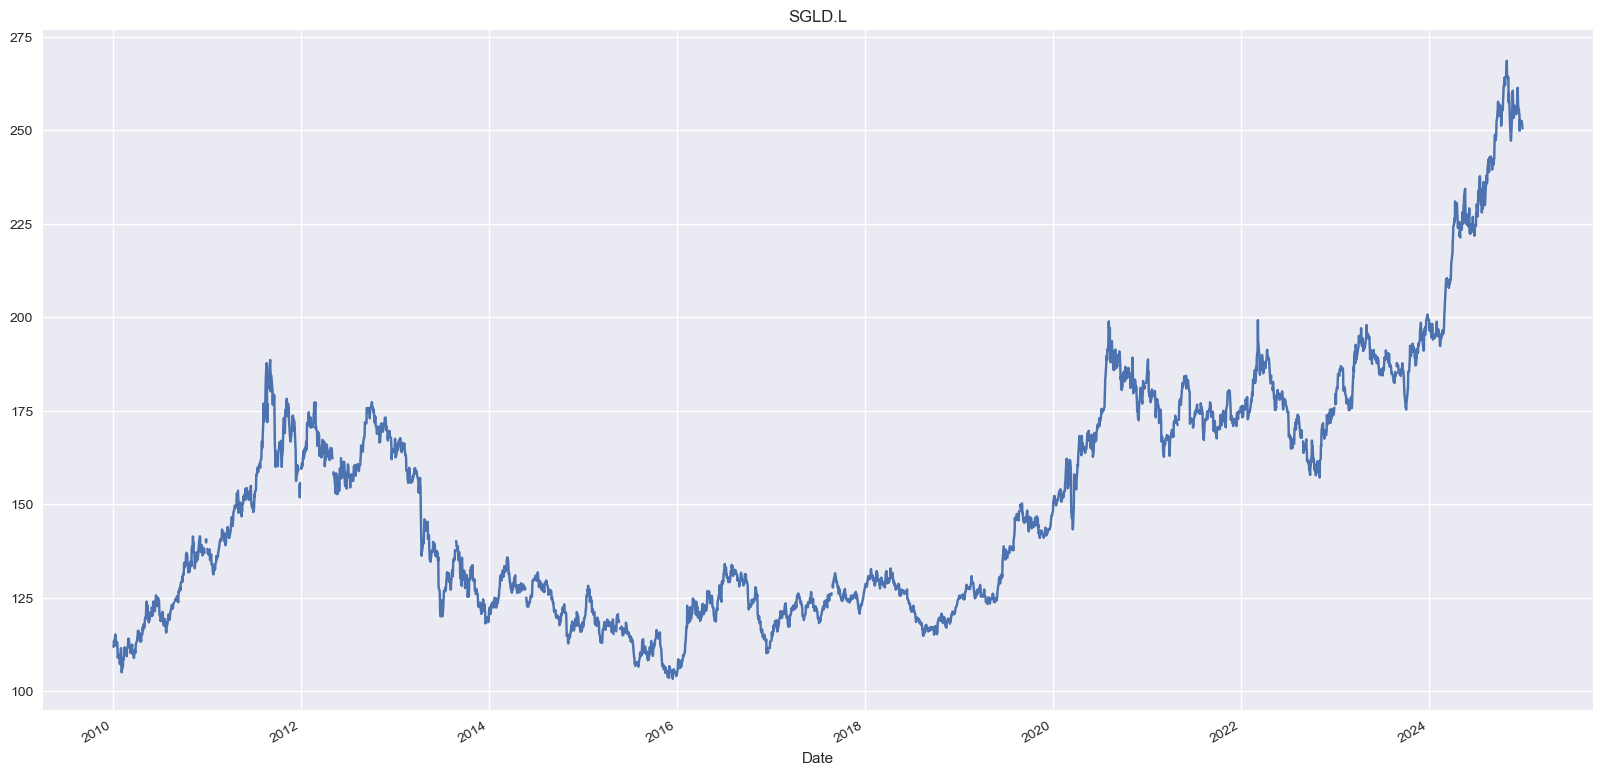

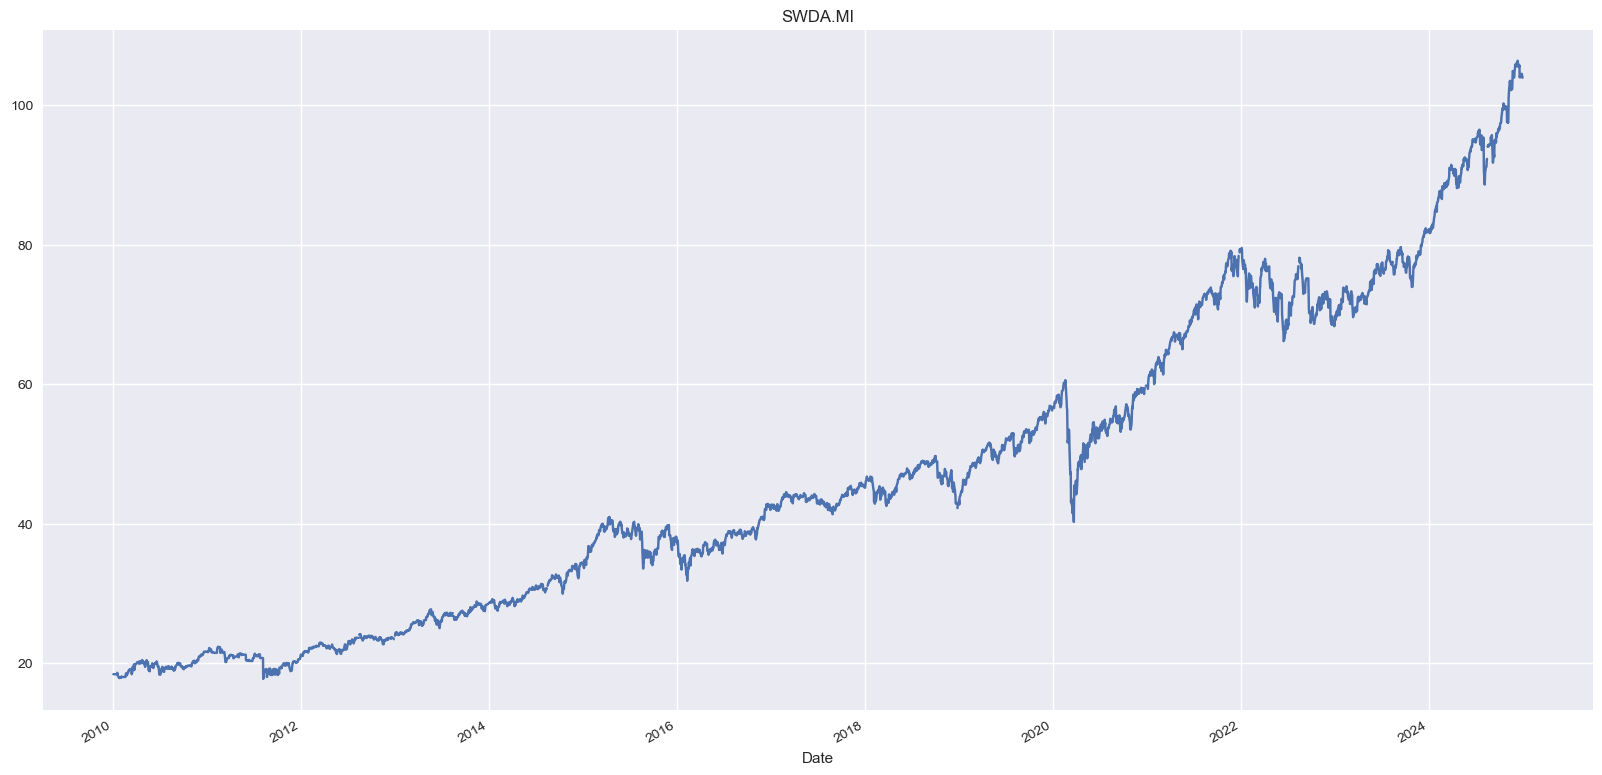

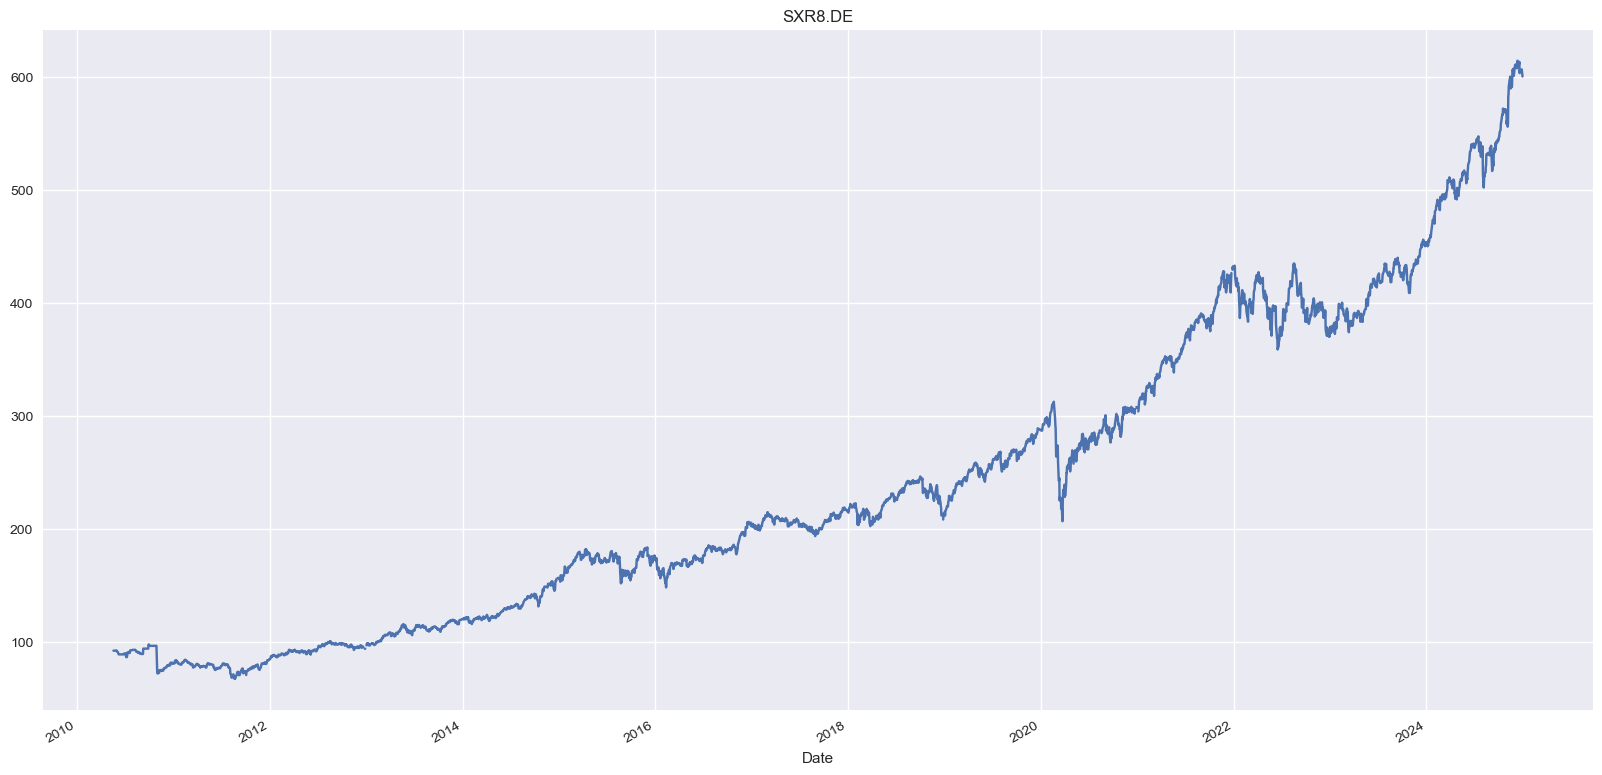

In [8]:
# plot to see the behaviour of the etfs considered
for c in data.columns:
  plt.figure()
  plt.title(c)
  data[c].plot(figsize=(20,10))
  plt.show()

In [9]:

#if "SEMA.L" in data.columns:
  #data["SEMA.L"].loc[:"2011-01-01"]=np.nan
#if "INRG.L" in data.columns:
  #data["INRG.L"].loc[:"2012-01-01"]=np.nan
#if "ISPY.L" in data.columns:
  #data["ISPY.L"].loc[:"2016-06-01"]=np.nan
#if "SWDA.L" in data.columns:
  #data["SWDA.L"].loc[:"2011-01-01"]=np.nan
#if "BATT.L" in data.columns:
  #data["BATT.L"].loc[:"2021-06-01"]=np.nan

# remove missing etfs and fill history if missing
data = data.dropna(axis=1, how='all')
data = data.ffill().bfill() 
data = data.dropna(axis=0, how='any') #remove dates if nan is still present
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3850 entries, 2010-01-04 to 2024-12-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SGLD.L   3850 non-null   float64
 1   SWDA.MI  3850 non-null   float64
 2   SXR8.DE  3850 non-null   float64
dtypes: float64(3)
memory usage: 120.3 KB


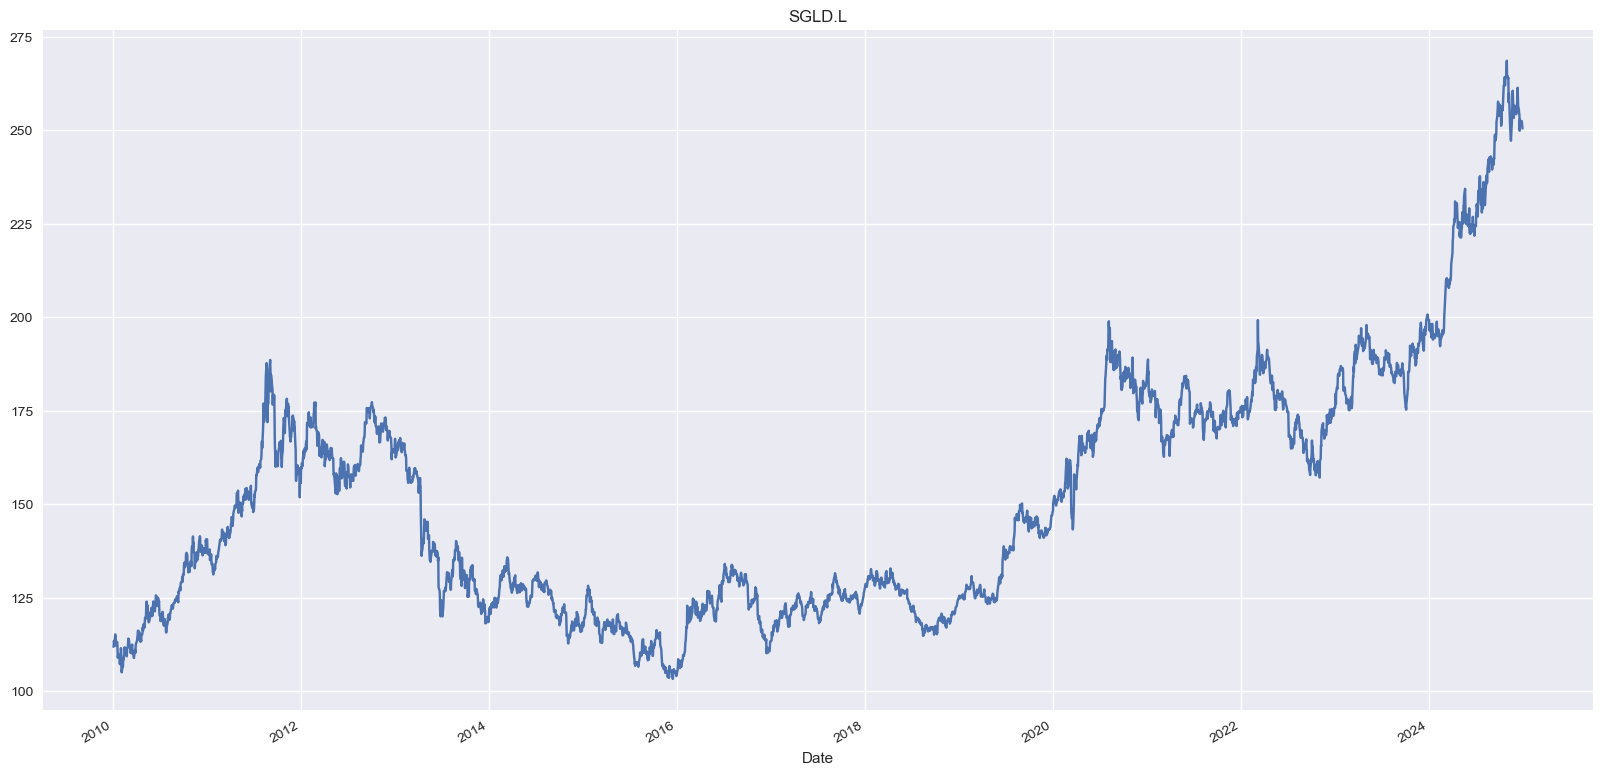

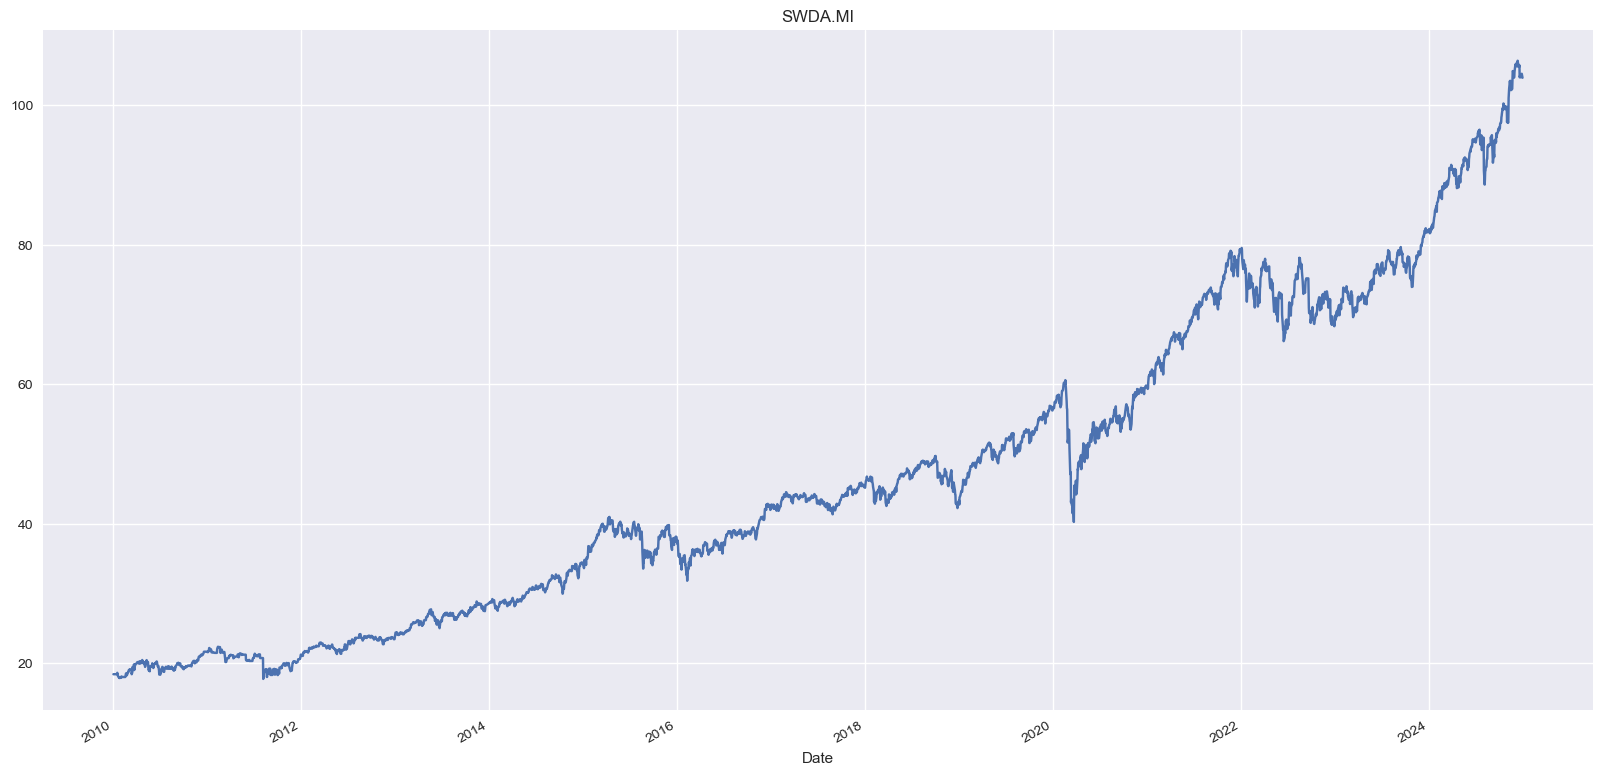

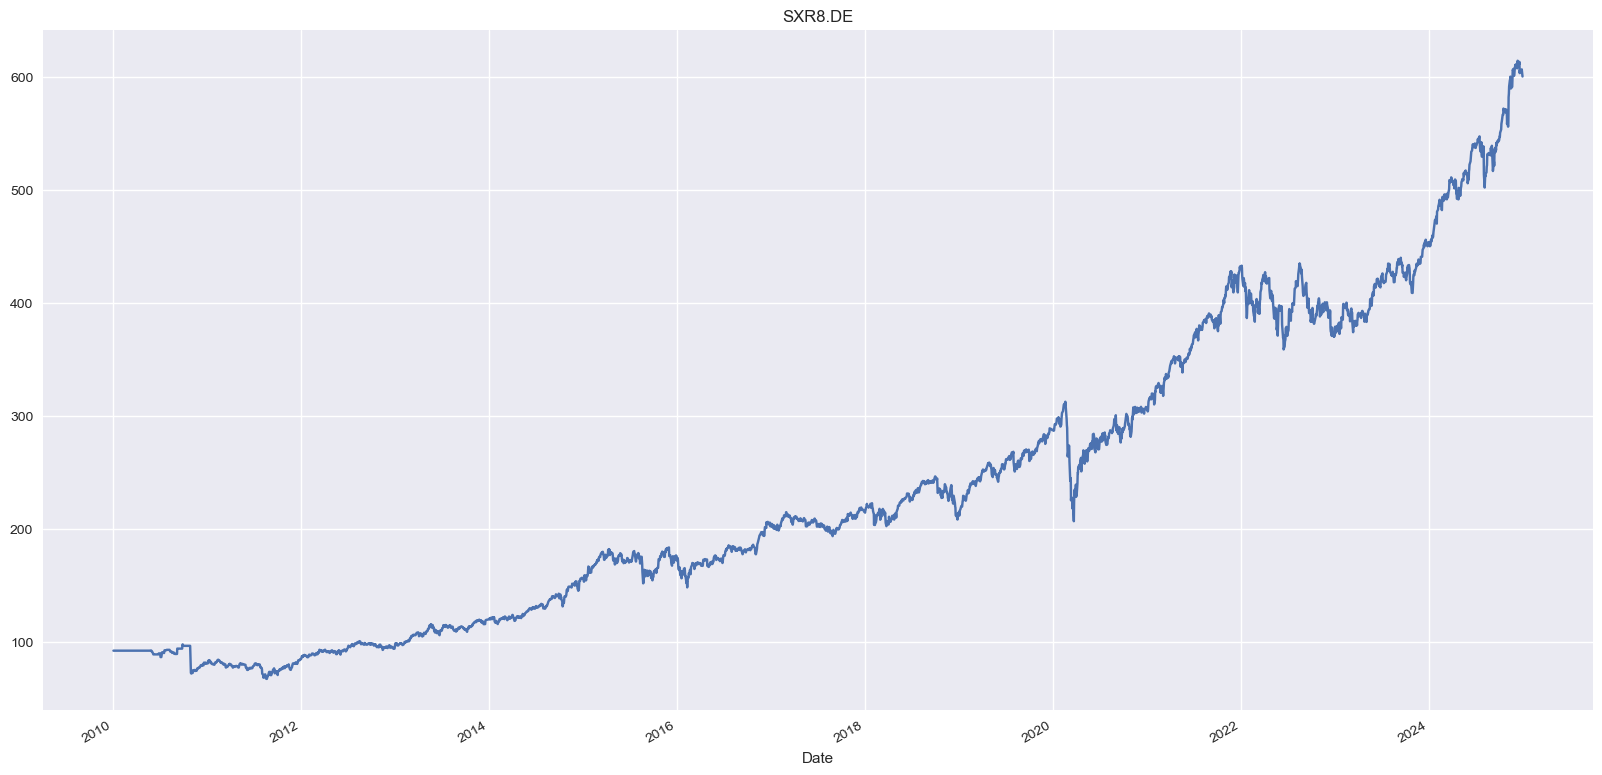

In [10]:
#double check
for c in data.columns:
  plt.figure()
  plt.title(c)
  data[c].plot(figsize=(20,10))
  plt.show()

In [11]:
etf_return = data.pct_change().dropna() # get returns
df_returns = etf_return.copy()
R_f = 0

<Axes: xlabel='Ticker', ylabel='Ticker'>

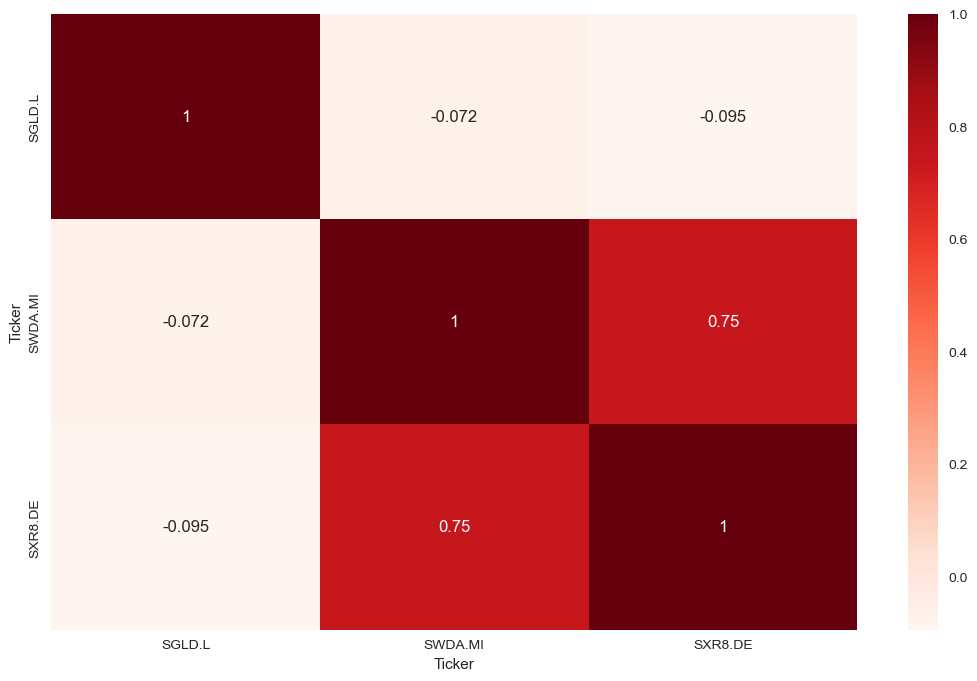

In [12]:
#correlation
plt.figure(figsize=(13,8))
#seaborn.set(font_scale=1.2)
seaborn.heatmap(df_returns.corr(),cmap="Reds", annot=True, annot_kws={"size":12})

In [13]:
#produce covariances and produce single stock portfolios
nomi = df_returns.columns.tolist()
annualized_decimal_means_ter_excluded = (df_returns.mean() + 1)**252 - 1
ter = (df_etf.sort_values(by="ticker")["ter"]/100).tolist()
annualized_decimal_means = annualized_decimal_means_ter_excluded - ter
print(annualized_decimal_means_ter_excluded)
print(ter)
print(annualized_decimal_means)
annualized_decimal_covariance = df_returns.cov() * 252
rows_table1 = []
for k in range(len(df_returns.columns)):
  w = np.zeros(len(df_returns.columns))
  w[k]=1.00
  w = w/sum(w)
  decimal_return = np.dot(annualized_decimal_means, w)
    
  # Calculate portfolio variance (annualized, decimal^2)
  variance_decimal = np.dot(w.T, np.dot(annualized_decimal_covariance, w))
    
  # Correct: Calculate volatility (annualized, decimal)
  vol_decimal = np.sqrt(variance_decimal) 
    
#convert to percentage for display in the table
  percentage_return = decimal_return * 100
  vol_percent = vol_decimal * 100
  R_f_decimal_for_sharpe = R_f / 100.0 if R_f > 1 else R_f # Adjust based on how R_f is defined

  sharpe = (decimal_return - R_f_decimal_for_sharpe) / vol_decimal if vol_decimal != 0 else np.inf
    
# Prepare the row data with percentages for rend, vol, and weights
  row_data = [percentage_return, vol_percent, sharpe] + list(w * 100)
  rows_table1.append(row_data)
table1 = pd.DataFrame(rows_table1, columns=["return", "volatility", "Sharpe"] + nomi)
print(table1)

Ticker
SGLD.L     0.066534
SWDA.MI    0.134368
SXR8.DE    0.146899
dtype: float64
[0.0015, 0.002, 0.0007000000000000001]
Ticker
SGLD.L     0.065034
SWDA.MI    0.132368
SXR8.DE    0.146199
dtype: float64
      return  volatility    Sharpe  SGLD.L  SWDA.MI  SXR8.DE
0   6.503361   15.262903  0.426089   100.0      0.0      0.0
1  13.236761   15.882566  0.833414     0.0    100.0      0.0
2  14.619872   16.888662  0.865662     0.0      0.0    100.0


In [14]:
# prduce randomly generated portfolios
rows_table = []
quante=50000
for k in range(quante):
  w=np.random.normal(1,0.2,len(df_returns.columns))
  w[w>1]=w[w>1]-1
  w = w/sum(w)
    
  decimal_return = np.dot(annualized_decimal_means, w)  
  # Calculate portfolio variance (annualized, decimal^2)
  variance_decimal = np.dot(w.T, np.dot(annualized_decimal_covariance, w))  
  # Calculate volatility (annualized, decimal)
  vol_decimal = np.sqrt(variance_decimal) 
  # convert to percentage for display in the table
  percentage_return = decimal_return * 100
  vol_percent = vol_decimal * 100
  R_f_decimal_for_sharpe = R_f / 100.0 if R_f > 1 else R_f # Adjust based on how R_f is defined

  sharpe = (decimal_return - R_f_decimal_for_sharpe) / vol_decimal if vol_decimal != 0 else np.inf
  row_data = [percentage_return, vol_percent, sharpe] + list(w * 100)
  rows_table.append(row_data)
  if k%10000==0:
    print(k)
table = pd.DataFrame(rows_table, columns=["return","volatility", "Sharpe"] + nomi)
table.head()

0
10000
20000
30000
40000


,return,volatility,Sharpe,SGLD.L,SWDA.MI,SXR8.DE
0,13.268025,13.825852,0.959653,14.361352,13.462881,72.175767
1,7.816183,12.593395,0.620657,82.141906,9.878636,7.979458
2,11.303031,10.859691,1.040824,37.304286,20.897393,41.798321
3,11.328233,10.864140,1.042718,35.099768,32.012062,32.888171
4,12.012961,12.017753,0.999601,32.017277,0.594675,67.388048


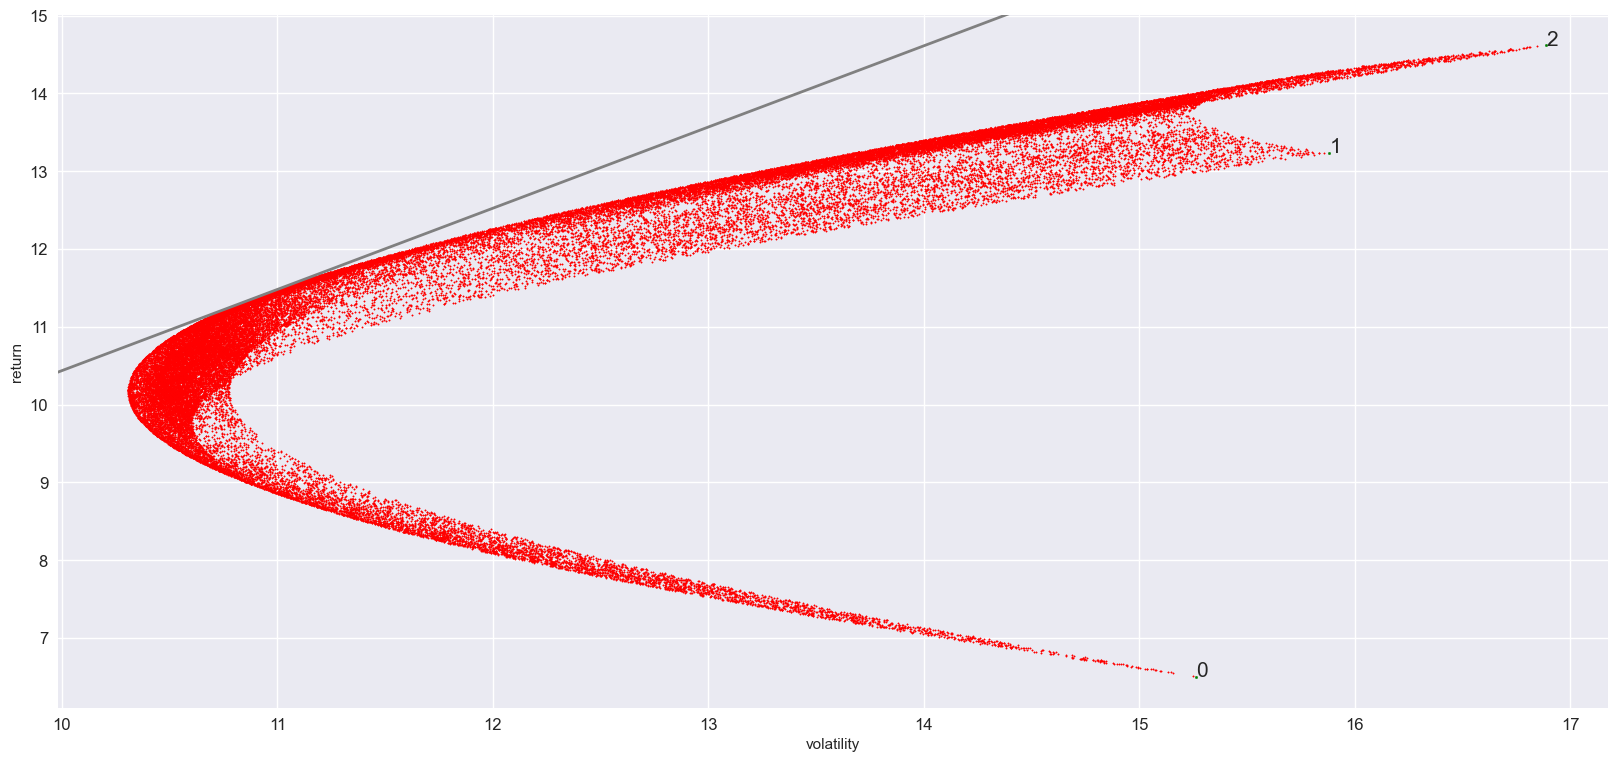

In [15]:
# print the scatter plot to see the efficient frontier and the CAL capital allocation line
ax = table.plot.scatter(x="volatility",y="return", figsize=(20,9),fontsize=12,s=1,color="r")
axes = plt.gca()
x=axes.get_xlim()
y=axes.get_ylim()
table1.plot.scatter(ax=ax,x="volatility",y="return", figsize=(20,9),fontsize=12,s=3,color="g",xlim=x,ylim=y)
#for i in table.index:
   #plt.annotate(i,xy=(table.loc[i,"volatility"],table.loc[i,"return"]),size=8)
for i in table1.index:
    plt.annotate(i,xy=(table1.loc[i,"volatility"],table1.loc[i,"return"]),size=15)
# print CAL
plt.plot([0, table.loc[table["Sharpe"].idxmax(), 'volatility'], table.loc[table["return"].idxmax(), 'volatility']], [R_f, table.loc[table["Sharpe"].idxmax(), 'return'], R_f+table["Sharpe"].max()*table.loc[table["return"].idxmax(), 'volatility']], color='grey', linestyle='-', linewidth=2, marker='o', markersize=1, label='Linea tra Punti')

In [16]:
table["Sharpe"].idxmax(),table.loc[table["Sharpe"].idxmax()]

(5291,
 return        11.379529
 volatility    10.902862
 Sharpe         1.043719
 SGLD.L        35.193630
 SWDA.MI       27.752502
 SXR8.DE       37.053869
 Name: 5291, dtype: float64)

In [17]:
table["volatility"].idxmin(),table.loc[table["volatility"].idxmin()]


(27000,
 return        10.173254
 volatility    10.307961
 Sharpe         0.986932
 SGLD.L        50.021610
 SWDA.MI       27.952127
 SXR8.DE       22.026263
 Name: 27000, dtype: float64)

In [18]:
table["return"].idxmax(),table.loc[table["return"].idxmax()]

(22567,
 return        14.607080
 volatility    16.847336
 Sharpe         0.867026
 SGLD.L         0.045074
 SWDA.MI        0.660311
 SXR8.DE       99.294615
 Name: 22567, dtype: float64)

In [19]:
table["volatility"].idxmax(),table.loc[table["volatility"].idxmax()]

(22567,
 return        14.607080
 volatility    16.847336
 Sharpe         0.867026
 SGLD.L         0.045074
 SWDA.MI        0.660311
 SXR8.DE       99.294615
 Name: 22567, dtype: float64)